In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
import re
import pickle
import scipy
import spacy
from spacy import displacy
from spacy.matcher import Matcher
import gensim 
from gensim.models.doc2vec import Doc2Vec
from operator import itemgetter
from gensim import corpora
from textblob import Word
from textblob import TextBlob
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.preprocessing import normalize,Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.cluster import KMeans 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score,pairwise_distances

In [59]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [60]:
job_data = pd.read_csv('data job posts.csv')

In [61]:
job_data.head()

jobpost          date  \
0  AMERIA Investment Consulting Company\nJOB TITL...   Jan 5, 2004   
1  International Research & Exchanges Board (IREX...   Jan 7, 2004   
2  Caucasus Environmental NGO Network (CENN)\nJOB...   Jan 7, 2004   
3  Manoff Group\nJOB TITLE:  BCC Specialist\nPOSI...   Jan 7, 2004   
4  Yerevan Brandy Company\nJOB TITLE:  Software D...  Jan 10, 2004   

                                               Title  \
0                            Chief Financial Officer   
1  Full-time Community Connections Intern (paid i...   
2                                Country Coordinator   
3                                     BCC Specialist   
4                                 Software Developer   

                                           Company AnnouncementCode Term  \
0             AMERIA Investment Consulting Company              NaN  NaN   
1  International Research & Exchanges Board (IREX)              NaN  NaN   
2        Caucasus Environmental NGO Network (CENN)              NaN  NaN   
3                                     Manoff Group              NaN  NaN   
4                           Yerevan Brandy Company              NaN  NaN   

  Eligibility Audience StartDate                             Duration  ...  \
0         NaN      NaN       NaN                                  NaN  ...   
1         NaN      NaN       NaN                             3 months  ...   
2         NaN      NaN       NaN  Renewable annual contract\nPOSITION  ...   
3         NaN      NaN       NaN                                  NaN  ...   
4         NaN      NaN       NaN                                  NaN  ...   

  Salary                                       ApplicationP OpeningDate  \
0    NaN  To apply for this position, please submit a\nc...         NaN   
1    NaN  Please submit a cover letter and resume to:\nI...         NaN   
2    NaN  Please send resume or CV toursula.kazarian@......         NaN   
3    NaN  Please send cover letter and resume to Amy\nPe...         NaN   
4    NaN  Successful candidates should submit\n- CV; \n-...         NaN   

                                      Deadline Notes  \
0                              26 January 2004   NaN   
1                              12 January 2004   NaN   
2  20 January 2004\nSTART DATE:  February 2004   NaN   
3      23 January 2004\nSTART DATE:  Immediate   NaN   
4                       20 January 2004, 18:00   NaN   

                                              AboutC Attach  Year Month     IT  
0                                                NaN    NaN  2004     1  False  
1  The International Research & Exchanges Board (...    NaN  2004     1  False  
2  The Caucasus Environmental NGO Network is a\nn...    NaN  2004     1  False  
3                                                NaN    NaN  2004     1  False  
4                                                NaN    NaN  2004     1   True  

[5 rows x 24 columns]

In [62]:
job_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             19001 non-null object
date                19001 non-null object
Title               18973 non-null object
Company             18994 non-null object
AnnouncementCode    1208 non-null object
Term                7676 non-null object
Eligibility         4930 non-null object
Audience            640 non-null object
StartDate           9675 non-null object
Duration            10798 non-null object
Location            18969 non-null object
JobDescription      15109 non-null object
JobRequirment       16479 non-null object
RequiredQual        18517 non-null object
Salary              9622 non-null object
ApplicationP        18941 non-null object
OpeningDate         18295 non-null object
Deadline            18936 non-null object
Notes               2211 non-null object
AboutC              12470 non-null object
Attach              1559 non-null object
Year              

## Data Exploration

### Job Posting by Year

In [63]:
y=pd.DataFrame(job_data.Year.value_counts().reset_index())
y['Job Posts']=y.Year
y['Year']=y['index']
y.drop('index',axis=1,inplace=True)
y.sort_values(by='Year',inplace=True)
y

Year  Job Posts
11  2004        875
9   2005       1138
10  2006       1116
6   2007       1538
4   2008       1785
8   2009       1191
7   2010       1511
5   2011       1697
0   2012       2149
2   2013       2009
3   2014       1983
1   2015       2009

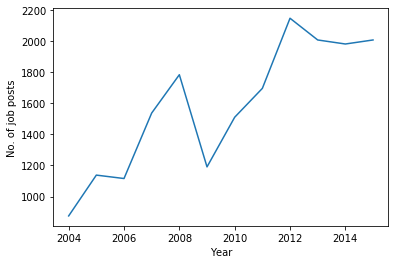

In [64]:
plt.plot('Year','Job Posts',data=y)
plt.xlabel('Year')
plt.ylabel('No. of job posts')
plt.show()

### Job Posting by Month

In [65]:
m=pd.DataFrame(job_data.Month.value_counts().reset_index())
m['Job Posts']=m.Month
m['Month']=m['index']
m.drop('index',axis=1,inplace=True)
m.sort_values(by='Month',inplace=True)
m

Month  Job Posts
11      1       1424
1       2       1665
0       3       1702
9       4       1466
7       5       1580
2       6       1662
6       7       1595
5       8       1613
3       9       1652
4      10       1637
8      11       1573
10     12       1432

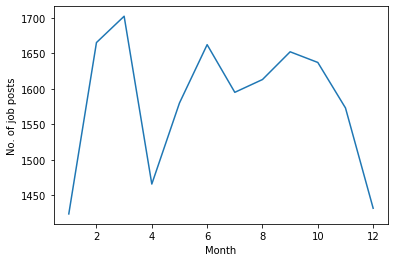

In [66]:
plt.plot('Month','Job Posts',data=m)
plt.xlabel('Month')
plt.ylabel('No. of job posts')
plt.show()

### Top Companies Job Posting

In [67]:
c=pd.DataFrame(job_data.Company.value_counts().reset_index())
c['Job Posts']=c.Company
c['Company']=c['index']
c.drop('index',axis=1,inplace=True)
c.sort_values(by='Job Posts',inplace=True,ascending=False)
c.head(10)

Company  Job Posts
0                              ArmenTel CJSC        353
1                       World Vision Armenia        239
2  Mentor Graphics Development Services CJSC        236
3                          Career Center NGO        229
4                             Orange Armenia        203
5                            Ameriabank CJSC        196
6                         Converse Bank CJSC        161
7                              SAS Group LLC        150
8                        UNDP Armenia Office        132
9                    Central Bank of Armenia        126

### Length of Job Post for Each Entry

In [68]:
words=[]
for i in range(job_data.shape[0]):
    words.append(len(job_data.jobpost.iloc[i].split()))

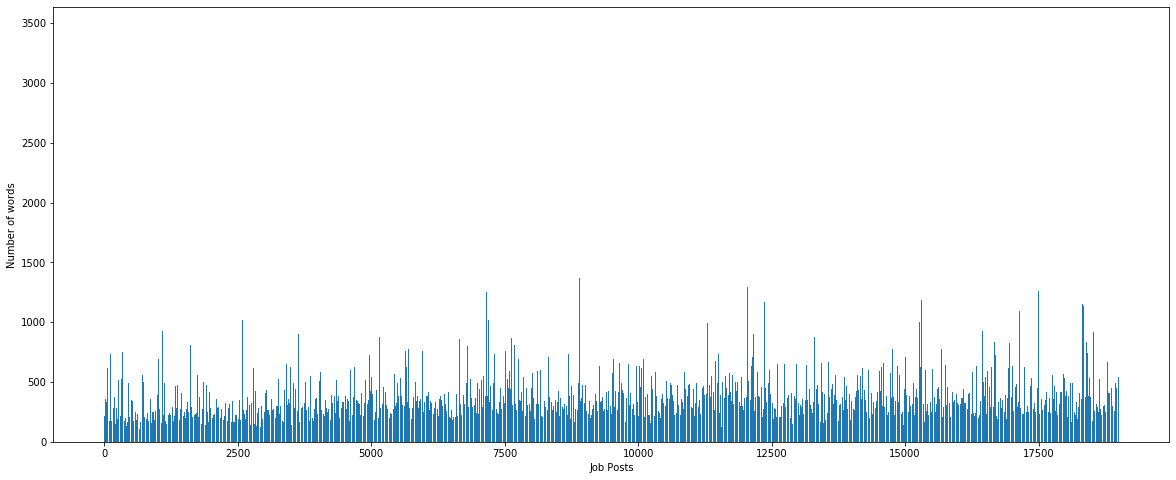

In [69]:
plt.figure(figsize=(20,8))
plt.bar(x=job_data.index,height=words)
plt.xlabel('Job Posts')
plt.ylabel('Number of words')
plt.show()

## Data Quality

### Missing Value Treatment

In [70]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean',filler='NA'):
        self.strategy = strategy
        self.fill = filler

    def fit(self, X, y=None):
        if self.strategy in ['mean','median']:
            if not all(X.dtypes == np.number):
                raise ValueError('dtypes mismatch np.number dtype is \
                                 required for '+ self.strategy)
        if self.strategy == 'mean':
            self.fill = X.mean()
        elif self.strategy == 'median':
            self.fill = X.median()
        elif self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname,v in zip(X.columns, self.fill)])
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [71]:
job_data=CustomImputer(strategy='mode').fit_transform(job_data)

In [72]:
job_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             19001 non-null object
date                19001 non-null object
Title               19001 non-null object
Company             19001 non-null object
AnnouncementCode    19001 non-null object
Term                19001 non-null object
Eligibility         19001 non-null object
Audience            19001 non-null object
StartDate           19001 non-null object
Duration            19001 non-null object
Location            19001 non-null object
JobDescription      19001 non-null object
JobRequirment       19001 non-null object
RequiredQual        19001 non-null object
Salary              19001 non-null object
ApplicationP        19001 non-null object
OpeningDate         19001 non-null object
Deadline            19001 non-null object
Notes               19001 non-null object
AboutC              19001 non-null object
Attach              19001 non-null object
Year     

### Duplicate Posts Removal

In [73]:
job_data.drop_duplicates(subset=['jobpost','Title'],inplace=True)

In [74]:
job_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18892 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             18892 non-null object
date                18892 non-null object
Title               18892 non-null object
Company             18892 non-null object
AnnouncementCode    18892 non-null object
Term                18892 non-null object
Eligibility         18892 non-null object
Audience            18892 non-null object
StartDate           18892 non-null object
Duration            18892 non-null object
Location            18892 non-null object
JobDescription      18892 non-null object
JobRequirment       18892 non-null object
RequiredQual        18892 non-null object
Salary              18892 non-null object
ApplicationP        18892 non-null object
OpeningDate         18892 non-null object
Deadline            18892 non-null object
Notes               18892 non-null object
AboutC              18892 non-null object
Attach              18892 non-null object
Year     

## Data Preparation

### Data Selection and Construction

In [75]:
job_data=job_data[['jobpost','Title','JobRequirment','JobDescription','RequiredQual','AboutC','IT','Year']]
job_data.head()

jobpost  \
0  AMERIA Investment Consulting Company\nJOB TITL...   
1  International Research & Exchanges Board (IREX...   
2  Caucasus Environmental NGO Network (CENN)\nJOB...   
3  Manoff Group\nJOB TITLE:  BCC Specialist\nPOSI...   
4  Yerevan Brandy Company\nJOB TITLE:  Software D...   

                                               Title  \
0                            Chief Financial Officer   
1  Full-time Community Connections Intern (paid i...   
2                                Country Coordinator   
3                                     BCC Specialist   
4                                 Software Developer   

                                       JobRequirment  \
0  - Supervises financial management and administ...   
1  - Participate in application design;\n- Provid...   
2  - Working with the Country Director to provide...   
3  - Identify gaps in knowledge and overseeing in...   
4  - Rendering technical assistance to Database M...   

                                      JobDescription  \
0  AMERIA Investment Consulting Company is seekin...   
1  The incumbent will work under the direct super...   
2  Public outreach and strengthening of a growing...   
3  The LEAD (Local Enhancement and Development fo...   
4  The incumbent will work under the direct super...   

                                        RequiredQual  \
0  To perform this job successfully, an\nindividu...   
1  - Bachelor's Degree; Master's is preferred;\n-...   
2  - Degree in environmentally related field, or ...   
3  - Advanced degree in public health, social sci...   
4  - University degree; economical background is ...   

                                              AboutC     IT  Year  
0  Mentor Graphics Development Services CJSC is a...  False  2004  
1  The International Research & Exchanges Board (...  False  2004  
2  The Caucasus Environmental NGO Network is a\nn...  False  2004  
3  Mentor Graphics Development Services CJSC is a...  False  2004  
4  Mentor Graphics Development Services CJSC is a...   True  2004

### Data Pre-processing

In [76]:
text=job_data[['jobpost','Title','JobRequirment','JobDescription','RequiredQual','AboutC']]
text.head()

jobpost  \
0  AMERIA Investment Consulting Company\nJOB TITL...   
1  International Research & Exchanges Board (IREX...   
2  Caucasus Environmental NGO Network (CENN)\nJOB...   
3  Manoff Group\nJOB TITLE:  BCC Specialist\nPOSI...   
4  Yerevan Brandy Company\nJOB TITLE:  Software D...   

                                               Title  \
0                            Chief Financial Officer   
1  Full-time Community Connections Intern (paid i...   
2                                Country Coordinator   
3                                     BCC Specialist   
4                                 Software Developer   

                                       JobRequirment  \
0  - Supervises financial management and administ...   
1  - Participate in application design;\n- Provid...   
2  - Working with the Country Director to provide...   
3  - Identify gaps in knowledge and overseeing in...   
4  - Rendering technical assistance to Database M...   

                                      JobDescription  \
0  AMERIA Investment Consulting Company is seekin...   
1  The incumbent will work under the direct super...   
2  Public outreach and strengthening of a growing...   
3  The LEAD (Local Enhancement and Development fo...   
4  The incumbent will work under the direct super...   

                                        RequiredQual  \
0  To perform this job successfully, an\nindividu...   
1  - Bachelor's Degree; Master's is preferred;\n-...   
2  - Degree in environmentally related field, or ...   
3  - Advanced degree in public health, social sci...   
4  - University degree; economical background is ...   

                                              AboutC  
0  Mentor Graphics Development Services CJSC is a...  
1  The International Research & Exchanges Board (...  
2  The Caucasus Environmental NGO Network is a\nn...  
3  Mentor Graphics Development Services CJSC is a...  
4  Mentor Graphics Development Services CJSC is a...

#### Removal of Newlines and Single Quotes

In [77]:
def remove_newline(text):
    text=re.sub(r'\n', '', text)                           # Replacing the new line with none
    text=re.sub(r"\'", '', text)                            # Replacing the single quotes with none
    return(text)

In [78]:
for i in text.columns:
    text[i] = text[i].apply(lambda x: remove_newline(x))

C:\Users\yashasvigoel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Removal of Emails, Web addresses and Telephone numbers

In [79]:
def remove_emails(text):
    text=re.sub(r'\S+@\S+','', text)                        # Replacing emails with none
    text=re.sub(r'http://\S+|https://\S+','', text)         # Replacing web addresses with none
    text=re.sub(r'(?:(?:\+?([1-9]|[0-9][0-9]|[0-9][0-9][0-9])\s*(?:[.-]\s*)?)?(?:\(\s*([2-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9])\s*\)|([0-9][1-9]|[0-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9]))\s*(?:[.-]\s*)?)?([2-9]1[02-9]|[2-9][02-9]1|[2-9][02-9]{2})\s*(?:[.-]\s*)?([0-9]{4})(?:\s*(?:#|x\.?|ext\.?|extension)\s*(\d+))?','', text)  # Remove telephone numbers
    return(text)

In [80]:
for i in text.columns:
    text[i] = text[i].apply(lambda x: remove_emails(x))

C:\Users\yashasvigoel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Removal of Punctuations and Conversion to Lower-case

In [81]:
def remove_punctuations(text):
    text=re.sub(r'!"#$%&()*,-./:;<=>?@\[]^_`{|}~','', text)                # Remove punctuations
    text=text.lower()                                       # Convert text to lower
    return(text)

In [82]:
for i in text.columns:
    text[i] = text[i].apply(lambda x: remove_punctuations(x))

C:\Users\yashasvigoel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Tokeninzation

In [83]:
def tokenization(text):
    text=word_tokenize(text)
    return(text)

In [84]:
token_text=pd.DataFrame()
for i in text.columns:
    token_text[i] = text[i].apply(lambda x: tokenization(x))

In [85]:
token_text

jobpost  \
0      [ameria, investment, consulting, companyjob, t...   
1      [international, research, &, exchanges, board,...   
2      [caucasus, environmental, ngo, network, (, cen...   
3      [manoff, groupjob, title, :, bcc, specialistpo...   
4      [yerevan, brandy, companyjob, title, :, softwa...   
5      [boutique, ``, appollo, '', job, title, :, sal...   
6      [osi, assistance, foundation, -, armenian, bra...   
7      [international, research, &, exchanges, board,...   
8      [yerevan, brandy, company, job, title, :, assi...   
9      [american, embassy, yerevanannouncement, numbe...   
10     [international, research, &, exchanges, board,...   
11     [international, research, &, exchanges, board,...   
12     [institute, for, sustainable, communities, (, ...   
13     [food, security, regional, cooperation, and, s...   
14     [teleplus, llcjob, title, :, general, managerp...   
15     [netcall, communicationsjob, title, :, network...   
16     [soc.stockholmtitle, :, utopian, world, champi...   
17     [united, nations, development, programme, ,, a...   
18     [counterpart, international, ,, inc.counterpar...   
19     [xalt, llcjob, title, :, graphic, designerposi...   
20     [cuts, centre, for, international, trade, ,, e...   
21     [yerevan, brandy, companyjob, title, :, lawyer...   
22     [acdi/vocajob, title, :, marketing, advisorpos...   
23     [armenia, tvjob, title, :, chief/, supervisor,...   
24     [media, diversity, institutejob, title, :, jou...   
25     [armenia, school, connectivity, programjob, ti...   
26     [yerevan, state, university, (, ysu, ), and, c...   
27     [media, diversity, institutejob, title, :, rep...   
28     [media, diversity, institutetitle, :, reportin...   
29     [sef, internationaljob, title, :, chief, accou...   
...                                                  ...   
18971  [career, center, ngotitle, :, receptionist/, a...   
18972  [essential, solutions, llctitle, :, java, ,, g...   
18973  [essential, solutions, llctitle, :, senior, ja...   
18974  [ltx-credence, armenia, llctitle, :, cad, libr...   
18975  [ltx-credence, armenia, llctitle, :, intern, (...   
18976  [sas, group, llctitle, :, senior, financial, s...   
18977  [strategic, development, agency, (, sda, ), ng...   
18978  [representation, of, the, ``, french, office, ...   
18979  [care, building, services, llctitle, :, projec...   
18980  [ltx-credence, armenia, llctitle, :, hardware,...   
18981  [bdo, armenia, cjsctitle, :, auditorstart, dat...   
18982  [bdo, armenia, cjsctitle, :, senior, auditorst...   
18983  [care, building, services, llctitle, :, constr...   
18984  [care, building, services, llctitle, :, electr...   
18985  [strategic, development, agency, (, sda, ), ng...   
18986  [strategic, development, agency, (, sda, ), ng...   
18987  [picsart, llctitle, :, junior, mobile, visual,...   
18988  [berg, development, llctitle, :, javascript, p...   
18989  [``, transport, piu, '', state, institution, o...   
18990  [nasdaq, omx, armenia, ojsctitle, :, java, dev...   
18991  [nasdaq, omx, armenia, ojsctitle, :, c/, c++, ...   
18992  [macadamian, ar, cjsctitle, :, .net, developer...   
18993  [``, coca-cola, hellenic, bottling, company, a...   
18994  [``, coca-cola, hellenic, bottling, company, a...   
18995  [``, transport, piu, '', state, institution, o...   
18996  [technolinguistics, ngotitle, :, senior, creat...   
18997  [``, coca-cola, hellenic, bottling, company, a...   
18998  [``, coca-cola, hellenic, bottling, company, a...   
18999  [san, lazzaro, llctitle, :, head, of, online, ...   
19000  [``, kamurj, '', uco, cjsctitle, :, lawyer, in...   

                                                   Title  \
0                            [chief, financial, officer]   
1      [full-time, community, connections, intern, (,...   
2                                 [country, coordinator]   
3                                      [bcc, specialist]   
4                           

#### Lemmatisation

In [86]:
def lemmatisation(text):
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))    # Lemmatization
    return(text)

In [87]:
for i in text.columns:
    text[i] = lemmatisation(text[i])

C:\Users\yashasvigoel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Extension of Stop-words

In [88]:
stop_words = stopwords.words('english')
stop_words.extend(['armenian','armenia','job','title','position','location','responsibilities','applications','procedures','deadline','required','qualifications','renumeration','salary','date','company','llc'])

In [89]:
def stop_word_removal(text):
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words)) #Removing stop words
    text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    return(text)

In [90]:
for i in text.columns:
    text[i] = stop_word_removal(text[i])

C:\Users\yashasvigoel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [91]:
text

jobpost  \
0      ameria investment consulting companyjob title:...   
1      international research & exchange board (irex)...   
2      caucasus environmental ngo network (cenn)job t...   
3      manoff groupjob title: bcc specialistposition ...   
4      yerevan brandy companyjob title: software deve...   
5      boutique "appollo"job title: saleswomanpositio...   
6      osi assistance foundation - branch officejob t...   
7      international research & exchange board (irex)...   
8      yerevan brandy title: assistant managing direc...   
9      american embassy yerevanannouncement number: 0...   
10     international research & exchange board (irex)...   
11     international research & exchange board (irex)...   
12     institute sustainable community (isc)job title...   
13     food security regional cooperation stability p...   
14     teleplus llcjob title: general managerposition...   
15     netcall communicationsjob title: network admin...   
16     soc.stockholmtitle: utopian world championship...   
17     united nation development programme, armeniajo...   
18     counterpart international, inc.counterparts co...   
19     xalt llcjob title: graphic designerposition lo...   
20     cut centre international trade, economics envi...   
21     yerevan brandy companyjob title: lawyerpositio...   
22     acdi/vocajob title: marketing advisorposition ...   
23     tvjob title: chief/ supervisor program departm...   
24     medium diversity institutejob title: journalis...   
25     school connectivity programjob title: deputy p...   
26     yerevan state university (ysu) civic education...   
27     medium diversity institutejob title: reporting...   
28     medium diversity institutetitle: reporting div...   
29     sef internationaljob title: chief accountantpo...   
...                                                  ...   
18971  career center ngotitle: receptionist/ administ...   
18972  essential solution llctitle: java, grails/ gro...   
18973  essential solution llctitle: senior java softw...   
18974  ltx-credence llctitle: cad librarian (printed ...   
18975  ltx-credence llctitle: intern ( coop tech): pr...   
18976  sa group llctitle: senior financial specialist...   
18977  strategic development agency (sda) ngotitle: b...   
18978  representation "french office immigration inte...   
18979  care building service llctitle: project assist...   
18980  ltx-credence llctitle: hardware engineerlocati...   
18981  bdo cjsctitle: auditorstart date/ time: asaplo...   
18982  bdo cjsctitle: senior auditorstart date/ time:...   
18983  care building service llctitle: construction s...   
18984  care building service llctitle: electrical eng...   
18985  strategic development agency (sda) ngotitle: p...   
18986  strategic development agency (sda) ngotitle: p...   
18987  picsart llctitle: junior mobile visual ui/ ux ...   
18988  berg development llctitle: javascript professi...   
18989  "transport piu" state institution ra ministry ...   
18990  nasdaq omx ojsctitle: java developerterm: full...   
18991  nasdaq omx ojsctitle: c/ c++ developerterm: fu...   
18992  macadamian ar cjsctitle: .net developerlocatio...   
18993  "coca-cola hellenic bottling armenia" cjsctitl...   
18994  "coca-cola hellenic bottling armenia" cjsctitl...   
18995  "transport piu" state institution ra ministry ...   
18996  technolinguistics ngotitle: senior creative ux...   
18997  "coca-cola hellenic bottling armenia" cjsctitl...   
18998  "coca-cola hellenic bottling armenia" cjsctitl...   
18999  san lazzaro llctitle: head online sale departm...   
19000  "kamurj" uco cjsctitle: lawyer legal departmen...   

                                                   Title  \
0                                chief financial officer   
1      full-time community connection intern (paid in...   
2                                    country coordinator   
3                                         bcc specialist   
4                           

#### Bigrams

In [92]:
def bigram(token_text):
    text=list(nltk.bigrams(token_text))
    return(text)

In [93]:
bigrams=pd.DataFrame()
for i in text.columns:
    bigrams[i] = token_text[i].apply(lambda x: bigram(x))

In [128]:
bigrams

jobpost  \
0      [(ameria, investment), (investment, consulting...   
1      [(international, research), (research, &), (&,...   
2      [(caucasus, environmental), (environmental, ng...   
3      [(manoff, groupjob), (groupjob, title), (title...   
4      [(yerevan, brandy), (brandy, companyjob), (com...   
5      [(boutique, ``), (``, appollo), (appollo, ''),...   
6      [(osi, assistance), (assistance, foundation), ...   
7      [(international, research), (research, &), (&,...   
8      [(yerevan, brandy), (brandy, company), (compan...   
9      [(american, embassy), (embassy, yerevanannounc...   
10     [(international, research), (research, &), (&,...   
11     [(international, research), (research, &), (&,...   
12     [(institute, for), (for, sustainable), (sustai...   
13     [(food, security), (security, regional), (regi...   
14     [(teleplus, llcjob), (llcjob, title), (title, ...   
15     [(netcall, communicationsjob), (communications...   
16     [(soc.stockholmtitle, :), (:, utopian), (utopi...   
17     [(united, nations), (nations, development), (d...   
18     [(counterpart, international), (international,...   
19     [(xalt, llcjob), (llcjob, title), (title, :), ...   
20     [(cuts, centre), (centre, for), (for, internat...   
21     [(yerevan, brandy), (brandy, companyjob), (com...   
22     [(acdi/vocajob, title), (title, :), (:, market...   
23     [(armenia, tvjob), (tvjob, title), (title, :),...   
24     [(media, diversity), (diversity, institutejob)...   
25     [(armenia, school), (school, connectivity), (c...   
26     [(yerevan, state), (state, university), (unive...   
27     [(media, diversity), (diversity, institutejob)...   
28     [(media, diversity), (diversity, institutetitl...   
29     [(sef, internationaljob), (internationaljob, t...   
...                                                  ...   
18971  [(career, center), (center, ngotitle), (ngotit...   
18972  [(essential, solutions), (solutions, llctitle)...   
18973  [(essential, solutions), (solutions, llctitle)...   
18974  [(ltx-credence, armenia), (armenia, llctitle),...   
18975  [(ltx-credence, armenia), (armenia, llctitle),...   
18976  [(sas, group), (group, llctitle), (llctitle, :...   
18977  [(strategic, development), (development, agenc...   
18978  [(representation, of), (of, the), (the, ``), (...   
18979  [(care, building), (building, services), (serv...   
18980  [(ltx-credence, armenia), (armenia, llctitle),...   
18981  [(bdo, armenia), (armenia, cjsctitle), (cjscti...   
18982  [(bdo, armenia), (armenia, cjsctitle), (cjscti...   
18983  [(care, building), (building, services), (serv...   
18984  [(care, building), (building, services), (serv...   
18985  [(strategic, development), (development, agenc...   
18986  [(strategic, development), (development, agenc...   
18987  [(picsart, llctitle), (llctitle, :), (:, junio...   
18988  [(berg, development), (development, llctitle),...   
18989  [(``, transport), (transport, piu), (piu, ''),...   
18990  [(nasdaq, omx), (omx, armenia), (armenia, ojsc...   
18991  [(nasdaq, omx), (omx, armenia), (armenia, ojsc...   
18992  [(macadamian, ar), (ar, cjsctitle), (cjsctitle...   
18993  [(``, coca-cola), (coca-cola, hellenic), (hell...   
18994  [(``, coca-cola), (coca-cola, hellenic), (hell...   
18995  [(``, transport), (transport, piu), (piu, ''),...   
18996  [(technolinguistics, ngotitle), (ngotitle, :),...   
18997  [(``, coca-cola), (coca-cola, hellenic), (hell...   
18998  [(``, coca-cola), (coca-cola, hellenic), (hell...   
18999  [(san, lazzaro), (lazzaro, llctitle), (llctitl...   
19000  [(``, kamurj), (kamurj, ''), ('', uco), (uco, ...   

                                                   Title  \
0             [(chief, financial), (financial, officer)]   
1      [(full-time, community), (community, connectio...   
2                               [(country, coordinator)]   
3                                    [(bcc, specialist)]   
4                           

#### Test Pre-prcessing on a Software Developer Job Post

In [25]:
sd=text[text.Title=='software developer']['jobpost']
frequency_words_wo_stop= {}
for data in sd:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if len(token)>=3:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

In [26]:
frequency_words_wo_stop

{'yerevan': 157,
 'brandy': 1,
 'companyjob': 1,
 'title': 11,
 'software': 562,
 'developerposition': 1,
 'location': 8,
 'armeniajob': 139,
 'responsibilities': 94,
 'rendering': 1,
 'technical': 124,
 'assistance': 13,
 'database': 81,
 'management': 37,
 'systems': 50,
 'realization': 1,
 'sql': 123,
 'server': 63,
 'maintenance': 7,
 'activities': 4,
 'back': 3,
 'andreplication': 1,
 'participation': 3,
 'designing': 9,
 'development': 276,
 'projects': 29,
 'required': 145,
 'qualifications': 152,
 'university': 28,
 'degree': 77,
 'economical': 1,
 'background': 19,
 'plus': 59,
 'excellent': 61,
 'knowledge': 429,
 'window': 26,
 '2000': 5,
 'networking': 2,
 'tcp': 3,
 'iptechnologies': 1,
 'visual': 24,
 'basic': 29,
 'least': 79,
 'year': 122,
 'experience': 353,
 'good': 179,
 'english': 122,
 'remuneration': 95,
 'commensurate': 3,
 'norm': 1,
 'accepted': 1,
 'thecompany': 5,
 'application': 389,
 'procedures': 147,
 'successful': 18,
 'candidate': 119,
 'submit': 21,
 '

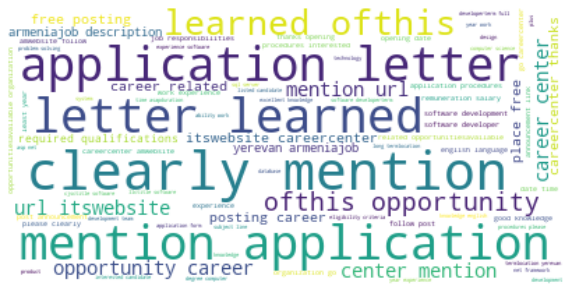

In [27]:
wordcloud = WordCloud(background_color="white").generate(' '.join(sd))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloud,interpolation='bilinear')

# Text Mining

## Supervised Learning

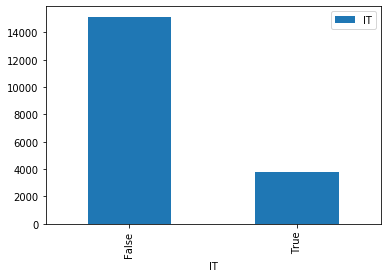

In [26]:
job_data.groupby(['IT']).agg({'IT':'count'}).plot.bar()

### TF-IDF Based Classification

In [27]:
vectorizer=TfidfVectorizer()
X_tfidf= vectorizer.fit_transform(text.jobpost)

#### Use SVD to reduce dimensions

In [28]:
svd = TruncatedSVD(1500)
X_tfidf=svd.fit_transform(X_tfidf)

In [29]:
print(svd.explained_variance_ratio_.sum())  

0.6538547808027819


In [30]:
X_tfidf.shape

(18892, 1500)

#### Convert imbalanced data to balanced data by Up-sample Minority Class

In [39]:
df.IT.value_counts()

0.0    15144
1.0     3748
Name: IT, dtype: int64

In [38]:
X_tfidf=pd.DataFrame(X_tfidf)
it['IT']=pd.get_dummies(job_data.IT,drop_first=True)
df=pd.concat([X_tfidf,it.IT],axis=1)
df.head()

0         1         2         3         4         5         6  \
0  0.271872 -0.153256  0.207146  0.121158  0.029393  0.144493 -0.100285   
1  0.171777 -0.043785 -0.036728  0.113057  0.065262 -0.061431  0.054769   
2  0.134533 -0.034058 -0.027754  0.083890  0.027635 -0.034357  0.025453   
3  0.170536  0.012834 -0.029139  0.158266 -0.015115  0.011682  0.022639   
4  0.215542  0.091776  0.028051 -0.012283  0.030188 -0.059953 -0.005955   

          7         8         9  ...      1491      1492      1493      1494  \
0  0.034176 -0.020445 -0.023723  ... -0.001380  0.007336  0.001985 -0.002886   
1 -0.040832 -0.003506  0.027258  ...  0.017129  0.000355 -0.014995 -0.009629   
2 -0.025357  0.006092  0.010402  ...  0.011349  0.015024  0.014629  0.011111   
3  0.001212 -0.037258 -0.018241  ... -0.015327  0.005575 -0.025924  0.021094   
4 -0.015061 -0.007239 -0.032827  ... -0.010234 -0.000239  0.006148 -0.002469   

       1495      1496      1497      1498      1499   IT  
0  0.004055  0.007283 -0.000648 -0.007527 -0.006814  0.0  
1 -0.011558  0.003746  0.011029 -0.003216 -0.012380  0.0  
2 -0.017971 -0.003038  0.010691  0.006417  0.007680  0.0  
3 -0.001856  0.000444 -0.010874  0.013048  0.005788  0.0  
4  0.018982  0.019681 -0.010294  0.001348  0.006769  1.0  

[5 rows x 1501 columns]

In [40]:
# Separate majority and minority classes
df_majority = df[df.IT==0]
df_minority = df[df.IT==1]

In [41]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=15144,    # to match majority class
                                 random_state=123) # reproducible results

In [42]:
# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

In [43]:
df.IT.value_counts()

1.0    15144
0.0    15144
Name: IT, dtype: int64

In [44]:
#Handling missings
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

df=df.apply(Missing_imputation)

In [45]:
X=df.iloc[:,:-1]
y=df.IT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

21201
9087
21201
9087


### SVM

In [49]:
model = SVC(gamma='scale')

In [50]:
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
y_pred= model.predict(X_test)
y_pred

array([0., 0., 0., ..., 1., 0., 1.])

In [61]:
svm=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
svm

Actual  Predicted
17753     0.0        0.0
5234      1.0        0.0
241       0.0        0.0
14801     1.0        1.0
7945      0.0        0.0
10085     0.0        0.0
2878      1.0        1.0
13609     1.0        1.0
4442      0.0        0.0
10803     1.0        1.0
5300      1.0        1.0
18619     0.0        1.0
934       1.0        1.0
734       0.0        0.0
1253      1.0        1.0
627       1.0        1.0
18205     0.0        0.0
5949      1.0        0.0
3922      1.0        1.0
4310      1.0        1.0
3299      0.0        0.0
17153     1.0        1.0
14728     0.0        0.0
15829     0.0        0.0
9046      1.0        1.0
16627     1.0        1.0
1475      1.0        1.0
5604      1.0        1.0
17060     1.0        1.0
8097      0.0        0.0
...       ...        ...
14340     0.0        1.0
17919     1.0        1.0
16616     1.0        0.0
5333      0.0        0.0
10052     1.0        0.0
7584      0.0        0.0
3615      0.0        0.0
14272     0.0        1.0
8368      0.0        0.0
16753     1.0        1.0
5699      0.0        0.0
14591     1.0        0.0
6927      0.0        0.0
10466     0.0        1.0
694       0.0        0.0
11962     0.0        0.0
4627      1.0        1.0
17777     1.0        1.0
3754      0.0        0.0
14804     1.0        1.0
11815     0.0        0.0
18265     1.0        1.0
12290     0.0        0.0
9393      1.0        0.0
1256      1.0        1.0
14487     0.0        1.0
18913     1.0        0.0
949       1.0        1.0
18989     0.0        0.0
948       1.0        1.0

[9087 rows x 2 columns]

In [65]:
print("Accuracy :")
print(metrics.accuracy_score(svm.Actual,svm.Predicted))

Accuracy :
0.7857378672829317


Text(0.5, 15.0, 'Predicted label')

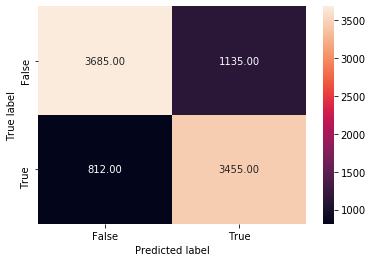

In [66]:
tree_cm = metrics.confusion_matrix(svm.Predicted, svm.Actual, [1,0])

sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["False", "True"] , yticklabels = ["False", "True"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [67]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78      4590
         1.0       0.76      0.82      0.79      4497

    accuracy                           0.79      9087
   macro avg       0.79      0.79      0.79      9087
weighted avg       0.79      0.79      0.79      9087



### RNN Based Classification

In [55]:
df=pd.DataFrame({'jobpost':text.jobpost,'IT':job_data.IT})
df.head()

jobpost     IT
0  ameria investment consulting companyjob chief ...  False
1  international research & exchange board (irex)...  False
2  caucasus environmental ngo network (cenn)job c...  False
3  manoff groupjob bcc specialistposition manila ...  False
4  yerevan brandy companyjob software developerpo...   True

In [163]:
nlp = spacy.load('en_core_web_sm')

In [140]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [141]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['jobpost'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 96575 unique tokens.


In [142]:
X = tokenizer.texts_to_sequences(df['jobpost'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (18892, 250)


In [143]:
Y = pd.get_dummies(df['IT']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (18892, 2)


In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [145]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.5))
model.add(LSTM(units=100))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 250, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


In [146]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3)

Train on 9256 samples, validate on 3968 samples
Epoch 1/5
9256/9256 [==============================] - ETA: 5:53 - loss: 0.6913 - acc: 0.687 - ETA: 3:42 - loss: 0.6835 - acc: 0.757 - ETA: 2:55 - loss: 0.6756 - acc: 0.802 - ETA: 2:30 - loss: 0.6683 - acc: 0.820 - ETA: 2:16 - loss: 0.6643 - acc: 0.812 - ETA: 2:05 - loss: 0.6600 - acc: 0.807 - ETA: 1:58 - loss: 0.6553 - acc: 0.796 - ETA: 1:53 - loss: 0.6467 - acc: 0.800 - ETA: 1:48 - loss: 0.6348 - acc: 0.809 - ETA: 1:45 - loss: 0.6282 - acc: 0.807 - ETA: 1:42 - loss: 0.6174 - acc: 0.809 - ETA: 1:40 - loss: 0.6000 - acc: 0.816 - ETA: 1:38 - loss: 0.5919 - acc: 0.816 - ETA: 1:36 - loss: 0.5956 - acc: 0.811 - ETA: 1:35 - loss: 0.5842 - acc: 0.814 - ETA: 1:33 - loss: 0.5834 - acc: 0.811 - ETA: 1:31 - loss: 0.5764 - acc: 0.812 - ETA: 1:30 - loss: 0.5690 - acc: 0.814 - ETA: 1:28 - loss: 0.5661 - acc: 0.813 - ETA: 1:27 - loss: 0.5620 - acc: 0.813 - ETA: 1:26 - loss: 0.5626 - acc: 0.810 - ETA: 1:25 - loss: 0.5540 - acc: 0.814 - ETA: 1:23 - loss:

9256/9256 [==============================] - ETA: 1:21 - loss: 0.2086 - acc: 0.937 - ETA: 1:22 - loss: 0.2603 - acc: 0.914 - ETA: 1:21 - loss: 0.2292 - acc: 0.921 - ETA: 1:21 - loss: 0.2654 - acc: 0.918 - ETA: 1:21 - loss: 0.2645 - acc: 0.918 - ETA: 1:20 - loss: 0.2377 - acc: 0.929 - ETA: 1:20 - loss: 0.2455 - acc: 0.924 - ETA: 1:19 - loss: 0.2540 - acc: 0.919 - ETA: 1:19 - loss: 0.2520 - acc: 0.920 - ETA: 1:18 - loss: 0.2687 - acc: 0.909 - ETA: 1:17 - loss: 0.2659 - acc: 0.909 - ETA: 1:16 - loss: 0.2667 - acc: 0.906 - ETA: 1:16 - loss: 0.2611 - acc: 0.909 - ETA: 1:15 - loss: 0.2569 - acc: 0.912 - ETA: 1:15 - loss: 0.2586 - acc: 0.911 - ETA: 1:14 - loss: 0.2594 - acc: 0.911 - ETA: 1:13 - loss: 0.2631 - acc: 0.911 - ETA: 1:13 - loss: 0.2576 - acc: 0.913 - ETA: 1:12 - loss: 0.2554 - acc: 0.913 - ETA: 1:12 - loss: 0.2565 - acc: 0.912 - ETA: 1:11 - loss: 0.2532 - acc: 0.914 - ETA: 1:11 - loss: 0.2529 - acc: 0.916 - ETA: 1:10 - loss: 0.2537 - acc: 0.917 - ETA: 1:09 - loss: 0.2537 - acc: 0.9

9256/9256 [==============================] - ETA: 1:24 - loss: 0.0820 - acc: 0.984 - ETA: 1:25 - loss: 0.1455 - acc: 0.960 - ETA: 1:24 - loss: 0.1434 - acc: 0.963 - ETA: 1:24 - loss: 0.1490 - acc: 0.964 - ETA: 1:22 - loss: 0.1306 - acc: 0.968 - ETA: 1:21 - loss: 0.1337 - acc: 0.968 - ETA: 1:21 - loss: 0.1477 - acc: 0.966 - ETA: 1:20 - loss: 0.1378 - acc: 0.968 - ETA: 1:19 - loss: 0.1358 - acc: 0.970 - ETA: 1:19 - loss: 0.1374 - acc: 0.970 - ETA: 1:18 - loss: 0.1354 - acc: 0.970 - ETA: 1:18 - loss: 0.1335 - acc: 0.970 - ETA: 1:17 - loss: 0.1312 - acc: 0.971 - ETA: 1:16 - loss: 0.1297 - acc: 0.972 - ETA: 1:16 - loss: 0.1262 - acc: 0.972 - ETA: 1:15 - loss: 0.1346 - acc: 0.969 - ETA: 1:15 - loss: 0.1382 - acc: 0.967 - ETA: 1:15 - loss: 0.1349 - acc: 0.968 - ETA: 1:15 - loss: 0.1341 - acc: 0.968 - ETA: 1:15 - loss: 0.1352 - acc: 0.968 - ETA: 1:14 - loss: 0.1347 - acc: 0.968 - ETA: 1:14 - loss: 0.1431 - acc: 0.965 - ETA: 1:13 - loss: 0.1425 - acc: 0.965 - ETA: 1:13 - loss: 0.1416 - acc: 0.9

In [147]:
accr = model.evaluate(X_test,y_test)

5668/5668 [==============================] - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

In [148]:
print('Test Loss: ',accr[0])
print('Test Accuracy: ',accr[1])

Test Loss:  0.2122594107444554
Test Accuracy:  0.9334862385321101


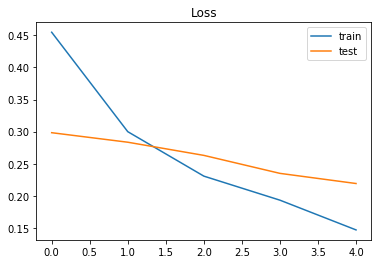

In [160]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

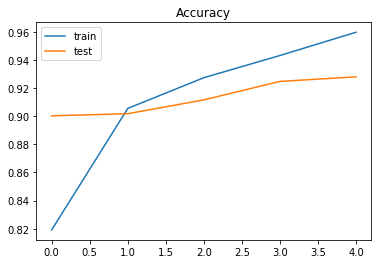

In [161]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [149]:
y_pred=model.predict_classes(X_test)
y_pred

In [156]:
rnn=pd.DataFrame({'Actual':y_test[:,1], 'Predicted':y_pred})
rnn

Actual  Predicted
0          1          1
1          0          0
2          0          0
3          0          0
4          0          0
5          0          0
6          0          0
7          0          0
8          1          1
9          0          0
10         0          0
11         1          1
12         0          0
13         0          0
14         0          0
15         0          0
16         0          0
17         0          0
18         0          0
19         0          0
20         0          0
21         1          1
22         1          0
23         0          0
24         0          0
25         0          0
26         0          0
27         0          0
28         0          0
29         0          0
...      ...        ...
5638       1          1
5639       0          0
5640       0          0
5641       0          0
5642       0          0
5643       1          1
5644       0          0
5645       0          0
5646       0          0
5647       0          0
5648       0          0
5649       0          0
5650       1          0
5651       0          0
5652       1          0
5653       1          0
5654       0          0
5655       0          0
5656       0          0
5657       1          1
5658       0          0
5659       0          0
5660       0          0
5661       0          0
5662       0          0
5663       0          0
5664       0          0
5665       0          0
5666       0          0
5667       0          0

[5668 rows x 2 columns]

Text(0.5, 15.0, 'Predicted label')

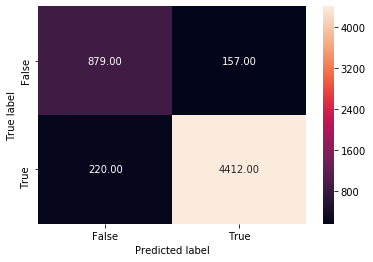

In [158]:
tree_cm = metrics.confusion_matrix(rnn.Predicted, rnn.Actual, [1,0])

sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["False", "True"] , yticklabels = ["False", "True"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [159]:
print(metrics.classification_report(y_test[:,1], y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4569
           1       0.85      0.80      0.82      1099

    accuracy                           0.93      5668
   macro avg       0.90      0.88      0.89      5668
weighted avg       0.93      0.93      0.93      5668



## Unsupervised Learning

### K-Means Clustering

In [28]:
text['RequiredQual_token'] = text['RequiredQual'].astype(str).map(word_tokenize)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
vec_tf = CountVectorizer(min_df=2)
required_qual_tf = vec_tf.fit_transform(text['RequiredQual'])
print(required_qual_tf.shape)

(18892, 13298)


In [30]:
required_qual_feature_names = (vec_tf.get_feature_names())
required_qual_feature_names[:10]

['00', '000', '04', '06', '0is', '0program', '0system', '10', '100', '10g']

In [32]:
vec_tfidf = TfidfVectorizer(max_df=0.7, min_df=3, use_idf=True)
required_qual_tfidf = vec_tfidf.fit_transform(text['RequiredQual'])
print(required_qual_tfidf.shape)

(18892, 9808)


In [34]:
pickle.dump(required_qual_tfidf, open("required_qual_tfidf.pkl", "wb"))
pickle.dump(vec_tfidf.vocabulary_, open("required_qual_tfidf_features.pkl", "wb"))

In [36]:
# Use SVD to reduce dimensions
svd = TruncatedSVD(1500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(required_qual_tfidf)

In [37]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 82%


In [38]:
range_n_clusters = list (range(4,11))

In [39]:
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_lsa)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X_lsa, preds, metric='euclidean')
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 4, silhouette score is 0.028743788309403006
For n_clusters = 5, silhouette score is 0.03022176915765527
For n_clusters = 6, silhouette score is 0.03102474561881931
For n_clusters = 7, silhouette score is 0.03216251679157303
For n_clusters = 8, silhouette score is 0.03238118480206424
For n_clusters = 9, silhouette score is 0.032756219555781
For n_clusters = 10, silhouette score is 0.03245742750342919


Best number of clusters are 9 because of highest silhouette score.

In [49]:
num_clusters = 9

for num in [num_clusters]:
    km3 = KMeans(n_clusters=num, init='k-means++', max_iter=1000, n_init=1, random_state=1)
    %time km3.fit(X_lsa)
    # The higher the better (-1 to 1)
    print("Clusters: {0}".format(num))
    print("Silhouette Coefficient for clusters: %0.3f"
          % metrics.silhouette_score(X_lsa, km3.labels_))

Wall time: 9.85 s
Clusters: 9
Silhouette Coefficient for clusters: 0.033


In [50]:
def print_terms(cm, num):
    original_space_centroids = svd.inverse_transform(cm.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vec_tfidf.get_feature_names()
    for i in range(num):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

print_terms(km3, num_clusters)

Cluster 0: language work good degree ability year university plus field russian
Cluster 1: net sql web development good javascript work html php server
Cluster 2: development testing software design ability programming good linux skills language
Cluster 3: sense responsibility high work skills ability excellent russian languages communication
Cluster 4: ability management skills work excellent skill strong degree project communication
Cluster 5: confident communicative timely punctual eager minded complete open manner mail
Cluster 6: accounting finance work tax financial year good excellent legislation software
Cluster 7: higher education work russian languages excellent skills computer good field
Cluster 8: skills excellent work russian languages university degree ability good communication


### Named Entity Recognition

In [28]:
nlp = spacy.load('en_core_web_lg')

In [34]:
def get_orgs_from_doc(document):
    doc = nlp(document)
    org_entities = ""
    
    for ent in doc.ents:
        stripped_content = ent.text.strip()
        if stripped_content != "" and stripped_content[0] != "-":
            if ent.label_ == "ORG":
                entity = ent.text
                entity = entity.replace("/", " ").replace("\n", " ")
                org_entities += entity + " "
                
    return org_entities

In [35]:
text["RequiredQualORGs"] = text["RequiredQual"].astype(str).apply(get_orgs_from_doc)
text["RequiredQualORGs"].head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    principles;- companysactivities;- needed;- exp...
1                                         preferred;- 
2                                                     
3                              preferred;- programs;- 
4                                                     
Name: RequiredQualORGs, dtype: object

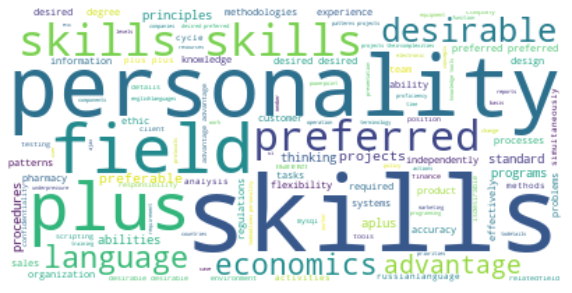

In [38]:
wordcloud = WordCloud(background_color="white").generate(' '.join(text.RequiredQualORGs))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloud,interpolation='bilinear')

### Topic Modelling to Determine Nature of Jobs over Time

In [33]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [39]:
text['jobpost_token'] = text.jobpost.map(word_tokenize)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
def pos_tag(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [65]:
text['jobpost_processed'] = pos_tag(text.jobpost_token, allowed_postags=['NOUN', 'VERB'])

In [43]:
text.jobpost_processed

[['investment',
  'consult',
  'companyjob',
  'title',
  'officerposition',
  'location',
  'yerevan',
  'armeniajob',
  'description',
  'investment',
  'consult',
  'seek',
  'officer',
  'manage',
  'function',
  'provide',
  'technicallycomplex',
  'staff',
  'assistance',
  'executive',
  'director',
  'work',
  'performedrequire',
  'level',
  'proficiency',
  'managementand',
  'investment',
  'management',
  'management',
  'responsibility',
  'supervise',
  'management',
  'staff',
  'includingassigne',
  'responsibility',
  'review',
  'employee',
  'work',
  'process',
  'andproduct',
  'counsel',
  'employee',
  'give',
  'performance',
  'evaluation',
  'andrecommende',
  'action',
  'serf',
  'member',
  'management',
  'team',
  'participate',
  'strategicand',
  'planning',
  'company',
  'direct',
  'oversee',
  'management',
  'activity',
  'include',
  'establish',
  'monitor',
  'control',
  'manage',
  'cashand',
  'investment',
  'manage',
  'investment',
  'port

In [44]:
dictionary = corpora.Dictionary(text.jobpost_processed)
dictionary.filter_extremes(no_below=3, no_above=0.7)

In [49]:
dtm_train = [dictionary.doc2bow(d) for d in text.jobpost_processed]
lda = gensim.models.ldamodel.LdaModel(dtm_train,num_topics=7,alpha='auto',chunksize=30,id2word=dictionary,passes=20)
dtopics_train = lda.get_document_topics(dtm_train)

In [50]:
lda.show_topics()

[(0,
  '0.036*"project" + 0.021*"development" + 0.017*"ensure" + 0.016*"management" + 0.014*"activity" + 0.014*"support" + 0.013*"program" + 0.012*"ability" + 0.011*"plan" + 0.011*"implementation"'),
 (1,
  '0.032*"level" + 0.025*"website" + 0.019*"roam" + 0.018*"press" + 0.017*"shift" + 0.016*"note" + 0.014*"proceed" + 0.014*"click" + 0.013*"can" + 0.013*"handle"'),
 (2,
  '0.031*"language" + 0.026*"training" + 0.022*"s" + 0.021*"attachment" + 0.020*"form" + 0.019*"medium" + 0.018*"student" + 0.016*"download" + 0.015*"council" + 0.014*"website"'),
 (3,
  '0.023*"office" + 0.017*"december" + 0.012*"course" + 0.012*"document" + 0.009*"armenia" + 0.009*"provide" + 0.009*"language" + 0.009*"coordinator" + 0.008*"support" + 0.008*"draft"'),
 (4,
  '0.019*"candidate" + 0.017*"ability" + 0.017*"language" + 0.013*"company" + 0.012*"yerevan" + 0.012*"service" + 0.012*"time" + 0.011*"communication" + 0.011*"line" + 0.010*"salary"'),
 (5,
  '0.030*"software" + 0.029*"development" + 0.027*"design

In [62]:
pd.DataFrame({'Topic':[0,1,2,3,4,5,6],
             'Nature of Job':['Project Development','Website','Language Training','Language Coordinator','Communication','Software Development','Bank accounting and finance']})

Topic                Nature of Job
0      0          Project Development
1      1                      Website
2      2            Language Training
3      3         Language Coordinator
4      4                Communication
5      5         Software Development
6      6  Bank accounting and finance

In [53]:
top_train = [max(t, key=itemgetter(1))[0] for t in dtopics_train]

Text(0.5, 1.0, 'Topic Frequencies')

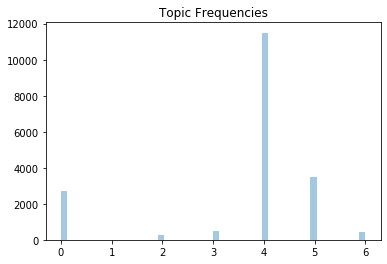

In [54]:
sns.distplot(top_train, kde=False).set_title('Topic Frequencies')

In [63]:
dictionary.save('dictionary.dict')

In [66]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text.jobpost_processed]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [67]:
lda.save('topic.model')

In [68]:
dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
corpus = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

In [75]:
pd.options.display.max_colwidth = 5000
data = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(data)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [76]:
pyLDAvis.save_html(data,'vis.html')

### Observing the Changes in Topics over the Years

In [55]:
topics = pd.Series(top_train)
text['topic'] = topics.values
text = pd.DataFrame(text)

In [57]:
df=pd.concat([text.topic,job_data.Year],axis=1)
df.head()

topic  Year
0      0  2004
1      3  2004
2      0  2004
3      0  2004
4      4  2004

#### For 2004-2007

Text(0.5, 1.0, 'Topic Frequencies 2004 - 2007')

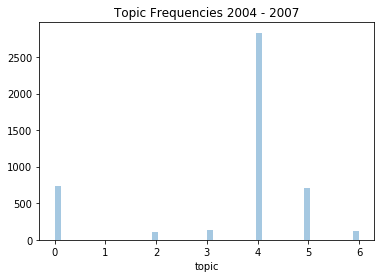

In [58]:
df_04to07 = df[df.Year <= 2007]
sns.distplot(df_04to07['topic'], kde=False).set_title('Topic Frequencies 2004 - 2007')

#### For 2008-2011

Text(0.5, 1.0, 'Topic Frequencies 2008 - 2011')

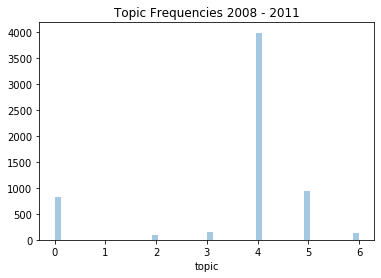

In [59]:
df_08to11 = df[(df['Year'] > 2007) & (df['Year'] <= 2011)]
sns.distplot(df_08to11['topic'], kde=False).set_title('Topic Frequencies 2008 - 2011')

#### For 2012-2015

Text(0.5, 1.0, 'Topic Frequencies 2012 - 2015')

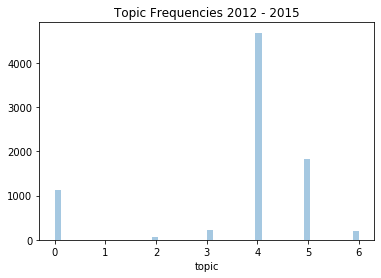

In [60]:
df_12to15 = df[(df['Year'] > 2011) & (df['Year'] <= 2015)]
sns.distplot(df_12to15['topic'], kde=False).set_title('Topic Frequencies 2012 - 2015')

## Information Extraction

### Information Extraction to obtain company profile

In [94]:
text['AboutC'].head()

0    mentor graphic development service cjsc subsid...
1    international research & exchange board (irex)...
2    caucasus environmental ngo network anon-govern...
3    mentor graphic development service cjsc subsid...
4    mentor graphic development service cjsc subsid...
Name: AboutC, dtype: object

In [95]:
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab)

In [96]:
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span
    match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'MATCH'}]
    matched_sents.append({'text': sent.text, 'ents': match_ents })

In [97]:
pattern1 = [{'POS':'ADJ'},{'ORTH': '-'}, {'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern2 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern3 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'company'}]
pattern4 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'services'}]
pattern5 = [{'LOWER': 'company'}, {'POS':'VERB'}, {'POS':'NOUN', 'OP':'+'}]
pattern6 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}  , {'POS':'CCONJ','OP':'+'}, {'POS':'NOUN','OP':'+'}]
pattern7 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}]
pattern8 = [{'POS':'VERB'}, {'POS':'NOUN',  'OP': '+'} ]
pattern9 = [{'POS':'ADJ'}, {'POS':'NOUN',  'OP': '+'} ]
pattern10 = [{'POS':'NOUN'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'} ]
pattern11 = [{'POS':'NOUN'}, {'POS':'NOUN','OP':'+'} ]

In [98]:
matcher.add('all', collect_sents, pattern1, pattern2, pattern3, pattern4, pattern5, pattern6, pattern7, pattern8, pattern9, pattern10, pattern11)

In [99]:
matched_sents=[]
for t in text.AboutC:
    if pd.notnull(t) and t != 'NaN':
        t = re.sub(r'\s+', ' ', t)
        doc = nlp(t)
        matches = matcher(doc)
        token_set = []
        for match_id, start, end in matches:
            string_id = nlp.vocab.strings[match_id]  # get string representation
            span = doc[start:end]  # the matched span
            token_set.append(span.text)    
        matched_sents.append(token_set)

In [100]:
flat_list = []
for row in matched_sents:
    for token in row:
        flat_list.append(token)

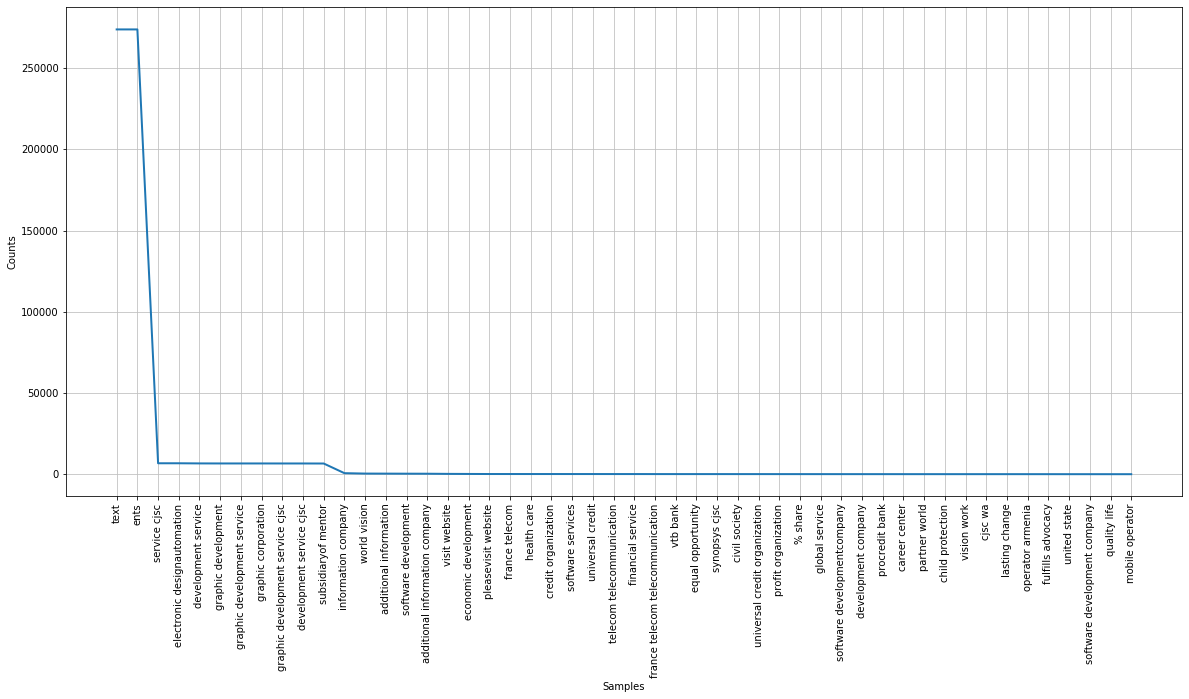

In [101]:
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(flat_list)  # case sensitive!
fd.most_common(50)
fd.plot(50)

### Job Similarity

#### Using TF-IDF

In [40]:
text['JobDescription_token'] = text['JobDescription'].map(word_tokenize)
text['RequiredQual_token'] = text['RequiredQual'].map(word_tokenize)
text['JobRequirment_token'] = text['JobRequirment'].map(word_tokenize)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
tfidf_model = TfidfVectorizer()
Title_tfidf = tfidf_model.fit_transform(text['Title'])
JobDescription_tfidf = tfidf_model.fit_transform(text['JobDescription'])
RequiredQual_tfidf = tfidf_model.fit_transform(text['RequiredQual'])
JobRequirment_tfidf = tfidf_model.fit_transform(text['JobRequirment'])

In [26]:
def find_similar_jobs_tfidf(index, top_n = 5):
    Title_tfidf_cosine = cosine_similarity(Title_tfidf[index:index+1], Title_tfidf).flatten()
    JobDescription_tfidf_cosine = cosine_similarity(JobDescription_tfidf[index:index+1], JobDescription_tfidf).flatten()
    RequiredQual_tfidf_cosine = cosine_similarity(RequiredQual_tfidf[index:index+1], RequiredQual_tfidf).flatten()
    JobRequirment_tfidf_cosine = cosine_similarity(JobRequirment_tfidf[index:index+1], JobRequirment_tfidf).flatten()

    average_cosine = (Title_tfidf_cosine +JobDescription_tfidf_cosine+RequiredQual_tfidf_cosine+JobRequirment_tfidf_cosine)/4.0
    related_docs_indices = [i for i in average_cosine.argsort()[::-1] if i != index]
    return [(index, average_cosine[index]) for index in related_docs_indices][0:top_n]

##### <u>1. Chief Financial Officer Jobs</u>

In [27]:
text.iloc[0]

jobpost           ameria investment consulting companyjob title:...
Title                                       chief financial officer
JobRequirment     - supervises financial management administrati...
JobDescription    ameria investment consulting seeking achief fi...
RequiredQual      perform successfully, anindividual must able p...
AboutC            mentor graphic development service cjsc subsid...
Name: 0, dtype: object

In [30]:
for index, score in find_similar_jobs_tfidf(0):
    print(text.iloc[index])
    print("SIMILARITY SCORE: ", score)

jobpost           "gritti" llctitle: chief financial officerterm...
Title                                       chief financial officer
JobRequirment     general responsibilities: - assist performing ...
JobDescription    gritti inviting highly qualifiedprofessionals ...
RequiredQual      - master equivalent university degree finance ...
AboutC            gritti franchisee stefano ricci andother fashi...
Name: 8120, dtype: object
SIMILARITY SCORE:  0.38595423509717625
jobpost           river islandtitle: chief financial officerloca...
Title                                       chief financial officer
JobRequirment     - develop tool system provide critical financi...
JobDescription    river island seeking chief financial officer w...
RequiredQual      - master degree management, finance economics;...
AboutC            aldi retail cjsc official representative ofclo...
Name: 11223, dtype: object
SIMILARITY SCORE:  0.37328005111062557
jobpost           organization implementation north-s

##### <u>2. International Research & Exchange Board Job</u>

In [31]:
text.iloc[1]

jobpost           international research & exchange board (irex)...
Title             full-time community connection intern (paid in...
JobRequirment     - participate application design;- provide nec...
JobDescription    incumbent work direct supervision ofthe presid...
RequiredQual      - bachelor degree; master preferred;- excellen...
AboutC            international research & exchange board (irex)...
Name: 1, dtype: object

In [32]:
for index, score in find_similar_jobs_tfidf(1):
    print(text.iloc[index])
    print("SIMILARITY SCORE: ", score)

jobpost           international research & exchange board (irex)...
Title                 non-paid part full time administrative intern
JobRequirment     - participate application design;- provide nec...
JobDescription    incumbent work direct supervision ofthe presid...
RequiredQual      - excellent communication skills;- good oral w...
AboutC            international research & exchange board (irex)...
Name: 11, dtype: object
SIMILARITY SCORE:  0.6698631101160857
jobpost           military institute mod rajob title: teacher (f...
Title                                           teacher (full time)
JobRequirment     - participate application design;- provide nec...
JobDescription    incumbent work direct supervision ofthe presid...
RequiredQual      - degree computer science, information technol...
AboutC            mentor graphic development service cjsc subsid...
Name: 114, dtype: object
SIMILARITY SCORE:  0.6606886749307502
jobpost           international research & exchange board (

##### <u>3. Caucasus Environmental NGO Network Job</u>

In [33]:
text.iloc[2]

jobpost           caucasus environmental ngo network (cenn)job t...
Title                                           country coordinator
JobRequirment     - working country director provide environment...
JobDescription    public outreach strengthening growingnetwork e...
RequiredQual      - degree environmentally related field, 5 year...
AboutC            caucasus environmental ngo network anon-govern...
Name: 2, dtype: object

In [34]:
for index, score in find_similar_jobs_tfidf(2):
    print(text.iloc[index])
    print("SIMILARITY SCORE: ", score)

jobpost           caucasus environmental ngo networktitle: count...
Title                                         country coordinator -
JobRequirment     - write first hand articles, conduct interview...
JobDescription    cenn - caucasus environmental ngo network - lo...
RequiredQual      1. education: university education environment...
AboutC            caucasus environmental ngo network anon-govern...
Name: 404, dtype: object
SIMILARITY SCORE:  0.4312987582388463
jobpost           veya limitedtitle: country coordinatorannounce...
Title                                           country coordinator
JobRequirment     - coordinate activity office staff middle east...
JobDescription    veya limited need experienced business manager...
RequiredQual      - university degree middle east studies, inter...
AboutC            veya limited multi-functional engaged inintern...
Name: 13497, dtype: object
SIMILARITY SCORE:  0.2683112946581559
jobpost           veya ltd.title: country coordinatorter

#### Using Pretrained Word2Vec Embedding

In [37]:
nlp = spacy.load('en_core_web_lg')

In [38]:
# Original text - Title
doc1 = nlp(text.iloc[0]['Title'])
doc2 = nlp(text.iloc[2]['Title'])
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

DOC1:
chief financial officer 

DOC2:
 country coordinator 

 0.5373299805896293


In [39]:
# Original text - RequiredQual
doc1 = nlp(text.iloc[0]['RequiredQual'])
doc2 = nlp(text.iloc[2]['RequiredQual'])
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

DOC1:
perform successfully, anindividual must able perform essential duty satisfactorily.the requirement listed representative knowledge,skill, and/or ability required.knowledge of:- generally accepted accounting principles;- local accounting standard legislation;- state reporting requirement pertaining accounting;- principle practice financial management budgeting;- principle practice financial system design analysis;- principle practice contract management, record management,and risk management;- principle practice management supervision;- principle practice information system management.ability to:- apply sound fiscal administrative practice companysactivities;- plan, organize supervise work subordinate employees,including training them, assigning evaluating work, andproviding performance feedback;- critically analyze fiscal administrative policies, practices,procedures, systems, recommend implement change needed;- gather synthesize financial information variety sourcesand present v

In [42]:
# removing stopwords and punctuations
doc1 = nlp(' '.join(text.iloc[0]['RequiredQual_token']))
doc2 = nlp(' '.join(text.iloc[2]['RequiredQual_token']))
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

DOC1:
perform successfully , anindividual must able perform essential duty satisfactorily.the requirement listed representative knowledge , skill , and/or ability required.knowledge of : - generally accepted accounting principles ; - local accounting standard legislation ; - state reporting requirement pertaining accounting ; - principle practice financial management budgeting ; - principle practice financial system design analysis ; - principle practice contract management , record management , and risk management ; - principle practice management supervision ; - principle practice information system management.ability to : - apply sound fiscal administrative practice companysactivities ; - plan , organize supervise work subordinate employees , including training them , assigning evaluating work , andproviding performance feedback ; - critically analyze fiscal administrative policies , practices , procedures , systems , recommend implement change needed ; - gather synthesize financial

##### POS + RegexMatcher

In [51]:
matcher = Matcher(nlp.vocab)

In [52]:
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span
    match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'MATCH'}]
    matched_sents.append({'text': sent.text, 'ents': match_ents })

In [53]:
pattern1 = [{'POS':'ADJ'},{'ORTH': '-'}, {'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern2 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern3 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'company'}]
pattern4 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'services'}]
pattern5 = [{'LOWER': 'company'}, {'POS':'VERB'}, {'POS':'NOUN', 'OP':'+'}]
pattern6 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}  , {'POS':'CCONJ','OP':'+'}, {'POS':'NOUN','OP':'+'}]
pattern7 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}]
pattern8 = [{'POS':'VERB'}, {'POS':'NOUN',  'OP': '+'} ]
pattern9 = [{'POS':'ADJ'}, {'POS':'NOUN',  'OP': '+'} ]
pattern10 = [{'POS':'NOUN'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'} ]
pattern11 = [{'POS':'NOUN'}, {'POS':'NOUN','OP':'+'} ]

In [54]:
matcher.add('all', collect_sents, pattern1, pattern2, pattern3, pattern4, pattern5, pattern6, pattern7, pattern8, pattern9, pattern10, pattern11)

In [55]:
# RequiredQual
for job1_idx in range(text.shape[0]):
    matched_sents = []
    keywords = []
    t = re.sub(r'\s+', ' ', text.iloc[job1_idx]['RequiredQual'])
    doc = nlp(t)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        keywords.append(span.text)
    text.set_value(job1_idx, 'RequiredQual_keywords', " ".join(keywords))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [60]:
# JobDescription
for job1_idx in range(text.shape[0]):
    matched_sents = []
    keywords = []
    t = re.sub(r'\s+', ' ', str(text.iloc[job1_idx]['JobDescription']))
    doc = nlp(t)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        keywords.append(span.text)
    text.set_value(job1_idx, 'JobDescription_keywords', " ".join(keywords))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [61]:
# JobRequirment
for job1_idx in range(text.shape[0]):
    matched_sents = []
    keywords = []
    t = re.sub(r'\s+', ' ', str(text.iloc[job1_idx]['JobRequirment']))
    doc = nlp(t)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        keywords.append(span.text)
    text.set_value(job1_idx, 'JobRequirment_keywords', " ".join(keywords))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [63]:
text.head(10)

jobpost  \
0  ameria investment consulting companyjob title:...   
1  international research & exchange board (irex)...   
2  caucasus environmental ngo network (cenn)job t...   
3  manoff groupjob title: bcc specialistposition ...   
4  yerevan brandy companyjob title: software deve...   
5  boutique "appollo"job title: saleswomanpositio...   
6  osi assistance foundation - branch officejob t...   
7  international research & exchange board (irex)...   
8  yerevan brandy title: assistant managing direc...   
9  american embassy yerevanannouncement number: 0...   

                                               Title  \
0                            chief financial officer   
1  full-time community connection intern (paid in...   
2                                country coordinator   
3                                     bcc specialist   
4                                 software developer   
5                                         saleswoman   
6                chief accountant/ finance assistant   
7        non-paid part full time programmatic intern   
8                        assistant managing director   
9              program assistant (inl), fsn-8; fp-6*   

                                       JobRequirment  \
0  - supervises financial management administrati...   
1  - participate application design;- provide nec...   
2  - working country director provide environment...   
3  - identify gap knowledge overseeing informatio...   
4  - rendering technical assistance database mana...   
5  - participate application design;- provide nec...   
6  - participate application design;- provide nec...   
7  - participate application design;- provide nec...   
8  - coordinating work subordinate employees;- ma...   
9  - participate application design;- provide nec...   

                                      JobDescription  \
0  ameria investment consulting seeking achief fi...   
1  incumbent work direct supervision ofthe presid...   
2  public outreach strengthening growingnetwork e...   
3  lead (local enhancement development forhealth)...   
4  incumbent work direct supervision ofthe presid...   
5              saleswoman sell menswear accessories.   
6  branch office open societyinstitute assistance...   
7  incumbent work direct supervision ofthe presid...   
8  incumbent work direct supervision ofthe presid...   
9  incumbent assist coordinating inl-funded lawen...   

                                        RequiredQual  \
0  perform successfully, anindividual must able p...   
1  - bachelor degree; master preferred;- excellen...   
2  - degree environmentally related field, 5 year...   
3  - advanced degree public health, social scienc...   
4  - university degree; economical background plu...   
5  - candidate female, 20-30 year old;- nice-look...   
6  - university degree finance/ accounting; - one...   
7  - excellent communication skills;- good oral w...   
8  - university degree;- least 3 year experience ...   
9  note: applicant instructed toaddress selection...   

                                              AboutC  \
0  mentor graphic development service cjsc subsid...   
1  international research & exchange board (irex)...   
2  caucasus environmental ngo network anon-govern...   
3  mentor graphic development service cjsc subsid...   
4  mentor graphic development service cjsc subsid...   
5  mentor graphic development service cjsc subsid...   
6  mentor graphic development service cjsc subsid...   
7  international research & exchange board (irex)...   
8  mentor graphic development service cjsc subsid...   
9  mentor graphic development service cjsc subsid...   

                                JobDescription_token  \
0  [ameria, investment, consulting, seeking, achi...   
1  [incumbent, work, direct, supervision, ofthe, ...   
2  [public, outreach, strengthening, growingnetwo...   
3  [lead, (, local, enhancement, development, for...   
4  [incumbent, work, direct, supervision, ofthe, ...   
5      

In [64]:
text.to_csv("job_similarity_df_with_keywords.csv", index=False, sep='\t')

In [65]:
job_dissimilarity_df = pd.DataFrame(columns=['index', 'similar-job', 'dissimilar-score'])

In [66]:
for job1_idx in range(3):  # rows
    for job2_idx in range(1000):

        doc1 = nlp(text.iloc[job1_idx]['Title'])
        doc2 = nlp(text.iloc[job2_idx]['Title'])
        title_similarity = doc1.similarity(doc2)
        
        doc1 = nlp(text.iloc[job1_idx]['JobDescription_keywords'])
        doc2 = nlp(text.iloc[job2_idx]['JobDescription_keywords'])
        jd_similarity = doc1.similarity(doc2)
        
        doc1 = nlp(text.iloc[job1_idx]['JobRequirment_keywords'])
        doc2 = nlp(text.iloc[job2_idx]['JobRequirment_keywords'])
        jr_similarity = doc1.similarity(doc2)
        
        doc1 = nlp(text.iloc[job1_idx]['RequiredQual_keywords'])
        doc2 = nlp(text.iloc[job2_idx]['RequiredQual_keywords'])
        rq_similarity = doc1.similarity(doc2)
        
        averaged_score = (title_similarity + jd_similarity + jr_similarity + rq_similarity) / 4.0
        job_dissimilarity_df = job_dissimilarity_df.append({'index': job1_idx, 'similar-job': job2_idx, 'dissimilar-score': (1-averaged_score)},ignore_index=True)

D:\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
D:\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
D:\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
D:\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
D:\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
D:\Anaconda3\lib\runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


In [67]:
# Top similar jobs
job_dissimilarity_df_sorted = job_dissimilarity_df.sort_values(by=['index', 'dissimilar-score'], ascending=[True, True])
job_dissimilarity_df_sorted.head(10)

index  similar-job  dissimilar-score
0      0.0          0.0          0.000000
859    0.0        859.0          0.105461
29     0.0         29.0          0.131710
776    0.0        776.0          0.131785
6      0.0          6.0          0.135498
42     0.0         42.0          0.138326
446    0.0        446.0          0.143852
72     0.0         72.0          0.145911
256    0.0        256.0          0.153281
970    0.0        970.0          0.154525

In [69]:
# Show top 5 similar results to job - Ameria Investment Consulting Job
similar_jobs = job_dissimilarity_df_sorted.loc[job_dissimilarity_df_sorted['index'] == 0].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(text.iloc[int(job)].replace(r'\n',' ', regex=True))

jobpost                    ameria investment consulting companyjob title:...
Title                                                chief financial officer
JobRequirment              - supervises financial management administrati...
JobDescription             ameria investment consulting seeking achief fi...
RequiredQual               perform successfully, anindividual must able p...
AboutC                     mentor graphic development service cjsc subsid...
JobDescription_token       [ameria, investment, consulting, seeking, achi...
RequiredQual_token         [perform, successfully, ,, anindividual, must,...
JobRequirment_token        [-, supervises, financial, management, adminis...
RequiredQual_keywords      essential duty representative knowledge abilit...
JobDescription_keywords    ameria investment ameria investment consulting...
JobRequirment_keywords     financial management administrative staff incl...
Name: 0, dtype: object
jobpost                    ameria cjsctitle: chief ac

In [71]:
# Show top 5 similar results to job - International Research & Exchange Board
similar_jobs = job_dissimilarity_df_sorted.loc[job_dissimilarity_df_sorted['index'] == 1].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(text.iloc[int(job)])

jobpost                    international research & exchange board (irex)...
Title                      full-time community connection intern (paid in...
JobRequirment              - participate application design;- provide nec...
JobDescription             incumbent work direct supervision ofthe presid...
RequiredQual               - bachelor degree; master preferred;- excellen...
AboutC                     international research & exchange board (irex)...
JobDescription_token       [incumbent, work, direct, supervision, ofthe, ...
RequiredQual_token         [-, bachelor, degree, ;, master, preferred, ;,...
JobRequirment_token        [-, participate, application, design, ;, -, pr...
RequiredQual_keywords      bachelor degree excellent skill english transl...
JobDescription_keywords    direct supervision ofthe president covering fr...
JobRequirment_keywords     participate application participate applicatio...
Name: 1, dtype: object
jobpost                    international research & e

In [72]:
# Show top 5 similar results to job - Caucasus Environmental NGO Network
similar_jobs = job_dissimilarity_df_sorted.loc[job_dissimilarity_df_sorted['index'] == 2].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(text.iloc[int(job)])

jobpost                    caucasus environmental ngo network (cenn)job t...
Title                                                    country coordinator
JobRequirment              - working country director provide environment...
JobDescription             public outreach strengthening growingnetwork e...
RequiredQual               - degree environmentally related field, 5 year...
AboutC                     caucasus environmental ngo network anon-govern...
JobDescription_token       [public, outreach, strengthening, growingnetwo...
RequiredQual_token         [-, degree, environmentally, related, field, ,...
JobRequirment_token        [-, working, country, director, provide, envir...
RequiredQual_keywords      related field year relevantexperience;- writte...
JobDescription_keywords    public outreach strengthening growingnetwork e...
JobRequirment_keywords     working country working country director count...
Name: 2, dtype: object
jobpost                    world vision armeniatitle: